In [999]:
# MTF073 Computational Fluid Dynamics
# Task 1: 2D diffusion
# Håkan Nilsson, 2023
# Department of Mechanics and Maritime Sciences
# Division of Fluid Dynamics
# Note that this is not efficient code. It is for educational purposes!

# Clear all variables when running entire code:
from IPython import get_ipython
get_ipython().run_line_magic('reset', '-sf')
# Packages needed
import numpy as np
import matplotlib.pyplot as plt
# Close all plots when running entire code:
plt.close('all')
# Set default font size in plots:
plt.rcParams.update({'font.size': 12})
import os # For saving plots

#===================== Inputs =====================

# Geometric and mesh inputs
L = 1 # Length of the domain in X direction
H = 2 # Length of the domain in Y direction  For non-equidistant meshes:
mI = 20 # Number of mesh points X direction. 
mJ = 20 # Number of mesh points Y direction. 
mesh_type = 'equidistant' # Set 'equidistant' or 'non-equidistant'
init_T = False

# Solver inputs

nIter  =  6000 # set maximum number of iterations
resTol =  0.00000001 # set convergence criteria for residuals

#====================== Code ======================

# Preparation of "nan", to fill empty slots in consistently numbered arrays.
# This makes it easier to check in Variable Explorer that values that should
# never be set are never set (or used). Plots simply omit nan values.
nan = float("nan")

# Allocate arrays (nan used to make clear where values need to be set)
# Note that some arrays could actually be 1D since they only have a variation
# in one direction, but they are kept 2D so the indexing is similar for all.
nI = mI + 1                    # Number of nodes in X direction, incl. boundaries
nJ = mJ + 1                    # Number of nodes in Y direction, incl. boundaries
pointX = np.zeros((mI,mJ))*nan # X coords of the mesh points
pointY = np.zeros((mI,mJ))*nan # Y coords of the mesh points
nodeX  = np.zeros((nI,nJ))*nan # X coords of the nodes
nodeY  = np.zeros((nI,nJ))*nan # Y coords of the nodes
dx_PE  = np.zeros((nI,nJ))*nan # X distance to east node
dx_WP  = np.zeros((nI,nJ))*nan # X distance to west node
dy_PN  = np.zeros((nI,nJ))*nan # Y distance to north node
dy_SP  = np.zeros((nI,nJ))*nan # Y distance to south node
dx_we  = np.zeros((nI,nJ))*nan # X size of the control volume
dy_sn  = np.zeros((nI,nJ))*nan # Y size of the control volume
aE     = np.zeros((nI,nJ))*nan # Array for east coefficient, in nodes
aW     = np.zeros((nI,nJ))*nan # Array for wect coefficient, in nodes
aN     = np.zeros((nI,nJ))*nan # Array for north coefficient, in nodes
aS     = np.zeros((nI,nJ))*nan # Array for south coefficient, in nodes
aP     = np.zeros((nI,nJ))*nan # Array for central coefficient, in nodes
Su     = np.zeros((nI,nJ))*nan # Array for source term for temperature, in nodes
Sp     = np.zeros((nI,nJ))*nan # Array for source term for temperature, in nodes
T      = np.zeros((nI,nJ))*nan # Array for temperature, in nodes
k      = np.zeros((nI,nJ))*nan # Array for conductivity, in nodes
k_e    = np.zeros((nI,nJ))*nan # Array for conductivity at east face
k_w    = np.zeros((nI,nJ))*nan # Array for conductivity at west face
k_n    = np.zeros((nI,nJ))*nan # Array for conductivity at north face
k_s    = np.zeros((nI,nJ))*nan # Array for conductivity at south face
res    = []                    # Array for appending residual each iteration



In [1000]:
# Generate mesh and compute geometric variables

if mesh_type == 'equidistant':
    # Calculate mesh point coordinates:
    for i in range(0, mI):
        for j in range(0, mJ):
            pointX[i,j] = i*L/(mI - 1)
            pointY[i,j] = j*H/(mJ - 1)
            

# Smaller to the top and bottom, aka the corners
#   -------------------------
#   | | | | | | | | | | | | |
#   -------------------------
#   | | |   |   |   |   | | |
#   | | |   |   |   |   | | |
#   -------------------------
#   | | | | | | | | | | | | |
#   -------------------------

if mesh_type == 'non-equidistant':
    # Calculate mesh point coordinates with stretching
    stretch = 1.10
    t_stretch = np.tanh(stretch)
    pointX[0,:] = 0
    pointY[:,0] = 0
    for i in range(1, mI):
        z2dp_x = ((2*i+1) - mI)/mI
        pointX[i,:] = (1 + np.tanh(stretch*z2dp_x)/t_stretch) * 0.5 * L
        
    for j in range(1, mJ):
        z2dp_y = ((2*j+1) - mJ)/mJ
        pointY[:,j] = (1 + np.tanh(stretch*z2dp_y)/t_stretch) * 0.5 * H
    pointX[-1,:] = L
    pointY[:,-1] = H

# Calculate node coordinates (same for equidistant and non-equidistant):
# Internal nodes:
for i in range(0, nI):
    for j in range(0, nJ):
        if i > 0 and i < nI-1:
            nodeX[i,j] = 0.5*(pointX[i,0] + pointX[i-1,0])
        if j > 0 and j < nJ-1:
            nodeY[i,j] = 0.5*(pointY[0,j] + pointY[0,j-1])
# Boundary nodes:
nodeX[0,:] = 0   # Note: corner points needed for contour plot
nodeY[:,0] = 0   # Note: corner points needed for contour plot
nodeX[-1,:] = L  # Note: corner points needed for contour plot
nodeY[:,-1] = H  # Note: corner points needed for contour plot


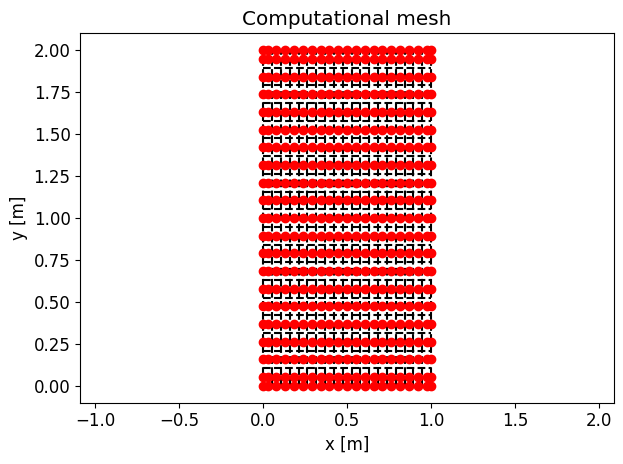

In [1001]:
# Plot mesh
plt.figure()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Computational mesh')
plt.axis('equal')
plt.vlines(pointX[:,0],0,H,colors = 'k',linestyles = 'dashed')
plt.hlines(pointY[0,:],0,L,colors = 'k',linestyles = 'dashed')
plt.plot(nodeX, nodeY, 'ro')
plt.savefig('mesh.png')
plt.tight_layout()
plt.show()



In [1002]:
# Calculate distances
# Keep 'nan' where values are not needed!
for i in range(1, nI-1):
    for j in range(1, nJ-1):
        dx_PE[i,j] = nodeX[i+1,j] - nodeX[i,j]
        dx_WP[i,j] = nodeX[i,j] - nodeX[i-1,j]
        dy_PN[i,j] = nodeY[i,j+1] - nodeY[i,j]
        dy_SP[i,j] = nodeY[i,j] - nodeY[i,j-1]
        dx_we[i,j] = pointX[i,j] - pointX[i-1,j]
        dy_sn[i,j] = pointY[i,j] - pointY[i,j-1]
        


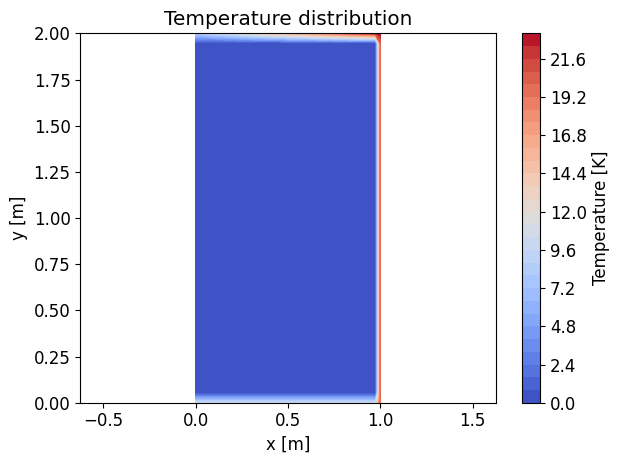

In [1003]:
# Initialize dependent variable array and Dirichlet boundary conditions
# Note that a value is needed in all nodes for contour plot
# ADD CODE HERE

T = np.zeros_like(T)
T1 = 10
T2 = 20
T3 = np.zeros_like(T[:,0])

T[:,0] = T1
T[-1,:] = T2
for i in range(0,nI):
    T3[i] = 5 + 3*(1 + 5*nodeX[i,j]/L)
    T[i,-1] = T3[i]


if init_T == True:
    T[0,:] = (T1+T2 + np.mean(T3))/3
    for i in range(1,nI-1):
        g_y = np.linspace(T[i,0], T[i,-1],nJ) # linear T on the given x coordinate from the bottom to the top
        for j in range(1,nJ-1):
            g_x = np.linspace(T[0,j], T[-1,j],nI) # linear T on the given y coordinate from the bottom to the top
            T[i,j] = (g_x[i]+g_y[j])/2


# Plot temperature contour
plt.figure()
plt.title('Temperature distribution')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
tempmap=plt.contourf(nodeX.T,nodeY.T,T.T,cmap='coolwarm',levels=30)
cbar=plt.colorbar(tempmap)
cbar.set_label('Temperature [K]')
plt.tight_layout()
plt.savefig('temp_init.png')


In [1004]:

c1 = 25
c2 = 0.25

F_vals = []
F_out_vals = []
error_vals = []
certain_T = []
certain_T_loc = (-4,-4)
for iteration in range(nIter):
    
    # Update conductivity arrays k, k_e, k_w, k_n, k_s, according to your case:
    # (could be moved to before iteration loop if independent of solution,
    # but keep here if you want to easily test different cases)
    # Keep 'nan' where values are not needed!
    # ADD CODE HERE.
    # k for cell midpoint
    for i in range(0,nI):
        for j in range(0, nJ):
            k[i,j] = 16*(nodeY[i,j]/H + 30*T[i,j]/T1)

    # interpolate to get the surface values for k
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
            fxe = dx_we[i,j]/dx_PE[i,j] * 0.5
            k_e[i,j] = k[i,j]*(1-fxe) +  fxe*k[i+1,j] 

            fxw = dx_we[i,j]/dx_WP[i,j] * 0.5
            k_w[i,j] = k[i,j] *(1-fxw) +  fxw*k[i-1,j] 

            fyn = dy_sn[i,j]/dy_PN[i,j] * 0.5
            k_n[i,j] = k[i,j] *(1-fyn) +  fyn*k[i,j+1]

            fys = dy_sn[i,j]/dy_SP[i,j] * 0.5
            k_s[i,j] = k[i,j] *(1-fys) +  fys*k[i,j-1]



    # Update source term array according to your case:
    # (could be moved to before iteration loop if independent of solution,
    # but keep here if you want to easily test different cases)
    # Keep 'nan' where values are not needed!
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
            Sp[i,j] = -15*c2*T[i,j] * dy_sn[i,j] * dx_we[i,j] 
            Su[i,j] = 15*c1 * dy_sn[i,j] * dx_we[i,j]
    
    # Calculate coefficients:
    # (could be moved to before iteration loop if independent of solution)
    # Keep 'nan' where values are not needed!
    # Inner node neighbour coefficients:
    # (not caring about special treatment at boundaries):
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
            Ae = dy_sn[i,j]
            Aw = dy_sn[i,j]
            As = dx_we[i,j]
            An = dx_we[i,j]

            aE[i,j] = Ae*k_e[i,j]/(dx_PE[i,j])
            aW[i,j] = Aw*k_w[i,j]/(dx_WP[i,j])
            aN[i,j] = An*k_n[i,j]/(dy_PN[i,j])
            aS[i,j] = As*k_s[i,j]/(dy_SP[i,j])
    

    # Modifications of aE and aW inside east and west boundaries:
    for j in range(1,nJ-1):
        i = nI-2 #East

        i=1 #West
        # Neumann-boundary condition
        aW[i,j] = 0
    # Modifications of aN and aS inside north and south boundaries:
    for i in range(1,nI-1):
        j = nJ-2 # North

        j=1 # South


    # Inner node central coefficients:
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
            aP[i,j] = aS[i,j] + aN[i,j] + aE[i,j] + aW[i,j] - Sp[i,j]

    # Solve for T using Gauss-Seidel:
    for i in range(1, nI - 1):
        for j in range(1, nJ - 1):
            T[i, j] = ((aW[i, j] * T[i - 1, j] + aE[i, j] * T[i + 1, j] + aS[i, j] * T[i, j - 1] + aN[i, j] * T[i, j + 1] + Su[i, j]) / aP[i, j])

    
    # Copy T to boundaries (and corners) where homegeneous Neumann is applied:
    for j in range(1, nJ - 1):
        i = 0  # West boundary
        T[i, j] = T[i + 1, j]  # dT/dx = 0
    
    # Compute and print residuals (taking into account normalization):
    r = 0
    for i in range(1, nI-1):
        for j in range(1, nJ-1):
            r += abs(aP[i,j]*T[i,j] - (aW[i,j]*T[i-1,j] + aE[i,j]*T[i+1,j] + aN[i,j]*T[i,j+1] + aS[i,j]*T[i,j-1] + Su[i,j]))

    F = 0
    F_out = 0
    dT_dx = np.zeros((nI, nJ))
    dT_dy = np.zeros((nI, nJ))
    # Calculate F_in and F_out from the domain
    # for i in range(1,nI-1):
    #     for j in range(1,nJ-1):
    #         dT_dx[i, j] = (T[i+1, j] - T[i-1, j]) / (dx_WP[i, j] + dx_PE[i,j])
    #         dT_dy[i, j] = (T[i, j+1] - T[i, j-1]) / (dy_SP[i, j]+ dy_PN[i,j])
    
    dT_dx,dT_dy = np.gradient(T,nodeX[:,0],nodeY[0,:])

    # Add positive source terms to F and negative to F_out
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
            if Sp[i,j]*T[i,j] > 0:
                F += abs(Sp[i,j]*T[i,j])
            else:
                F_out += abs(Sp[i,j]*T[i,j])
            if Su[i,j] > 0:
                F += abs(Su[i,j])
            else:
                F_out += abs(Su[i,j])

    # Compute energy in and out of the DOMAIN, at the borders.
    for i in range(1,nI-1):
        # South boundary
        j = 0
        # interpolate to get the wall temperature gradient
        dT_dy_s = (dT_dy[i,j] -  dT_dy[i, j+1])/dy_PN[i,j] * dy_SP[i,j] + dT_dy[i, j]
        F_s = -k[i, j] * dx_we[i, j+1] * dT_dy[i,j]
        if F_s > 0:
            F += abs(F_s)
        else:
            F_out += abs(F_s)

        # north boundary
        j = -1
        dT_dy_n = (dT_dy[i, j] -  dT_dy[i, j-1])/dy_SP[i,j] * dy_PN[i,j] + dT_dy[i, j]
        F_n = -k[i, j] * dx_we[i, j-1] * dT_dy[i,j]
        if F_n < 0:
            F += abs(F_n)
        else:
            F_out += abs(F_n)

    for j in range(1,nJ-1):
        # West boundary
        # due to neuman boundary, no heat transfer happens at the west boundary
        i = 0
        dT_dx_w = 0
        F_w = k[i, j] * dy_sn[i+1, j] * dT_dx[i,j]
        if F_w > 0:
            F += abs(F_w)
        else:
            F_out += abs(F_w)
        # East boundary
        i = -1
        dT_dx_e = (dT_dx[i, j] -  dT_dx[i-1, j])/dx_WP[i,j] * dx_PE[i,j] + dT_dx[i, j]
        F_e = -k[i, j] * dy_sn[i-1, j] * dT_dx[i,j]
        if F_e < 0:
            F += abs(F_e)
        else:
            F_out += abs(F_e)
            

            
    

    r /= F
    error = np.abs(F - F_out) / F *100
    if iteration%50 == 0:
        print('iteration: %5d, res = %.5e' % (iteration, r))
        print('Conservation of energy error: %.2f%%' % error, '\n')

    
    # Append residual at present iteration to list of all residuals, for plotting:
    certain_T.append(T[certain_T_loc])
    error_vals.append(error)
    res.append(r)
    F_vals.append(abs(F))
    F_out_vals.append(abs(F_out))
    
    # Stop iterations if converged:
    if r < resTol:
        print('iteration: %5d, res = %.5e' % (iteration, r))
        print('Conservation of energy error: %.2f%%' % error, '\n')
        break



iteration:     0, res = 7.35080e-01
Conservation of energy error: 73.51% 

iteration:    50, res = 5.26635e-01
Conservation of energy error: 52.66% 

iteration:   100, res = 3.22449e-01
Conservation of energy error: 32.24% 

iteration:   150, res = 1.92142e-01
Conservation of energy error: 19.21% 

iteration:   200, res = 1.11364e-01
Conservation of energy error: 11.14% 

iteration:   250, res = 6.33611e-02
Conservation of energy error: 6.34% 

iteration:   300, res = 3.56422e-02
Conservation of energy error: 3.56% 

iteration:   350, res = 1.99243e-02
Conservation of energy error: 1.99% 

iteration:   400, res = 1.10999e-02
Conservation of energy error: 1.11% 

iteration:   450, res = 6.17196e-03
Conservation of energy error: 0.62% 

iteration:   500, res = 3.42820e-03
Conservation of energy error: 0.34% 

iteration:   550, res = 1.90306e-03
Conservation of energy error: 0.19% 

iteration:   600, res = 1.05608e-03
Conservation of energy error: 0.11% 

iteration:   650, res = 5.85954e-

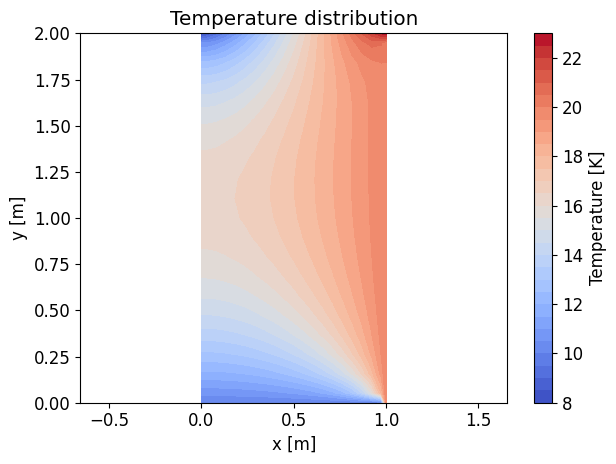

In [1005]:
# Plot temperature contour
plt.figure()
plt.title('Temperature distribution')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
tempmap=plt.contourf(nodeX.T,nodeY.T,T.T,cmap='coolwarm',levels=30)
cbar=plt.colorbar(tempmap)
cbar.set_label('Temperature [K]')
plt.tight_layout()

if mesh_type == 'equidistant':
    plt.savefig('Figures/equidistant/temperatureDistribution.png')
if mesh_type == 'non-equidistant':
    plt.savefig('Figures/non_equidistant/temperatureDistribution.png')


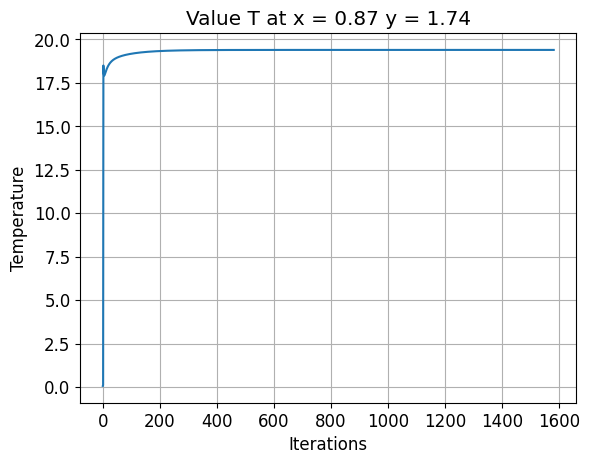

In [1006]:
# Plot residual convergence
plt.figure()
plt.title('Value T at x = %.2f y = %.2f'%(nodeX[certain_T_loc],nodeY[certain_T_loc]))
plt.xlabel('Iterations')
plt.ylabel('Temperature')
resLength = np.arange(0,len(certain_T),1)
plt.plot(resLength, certain_T)
plt.grid()

if mesh_type == 'equidistant':
    plt.savefig('Figures/equidistant/Certain_T.png')
if mesh_type == 'non-equidistant':
    plt.savefig('Figures/non_equidistant/Certain_T.png')

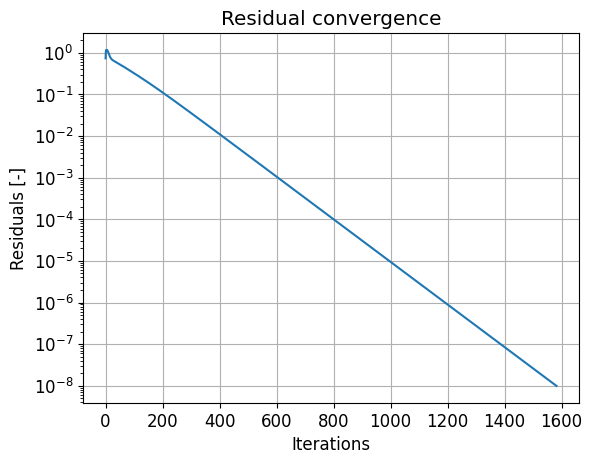

In [1007]:
# Plot residual convergence
plt.figure()
plt.title('Residual convergence')
plt.xlabel('Iterations')
plt.ylabel('Residuals [-]')
resLength = np.arange(0,len(res),1)
plt.plot(resLength, res)
plt.grid()
plt.yscale('log')

if mesh_type == 'equidistant':
    plt.savefig('Figures/equidistant/residualconvergence.png')
if mesh_type == 'non-equidistant':
    plt.savefig('Figures/non_equidistant/residualconvergence.png')


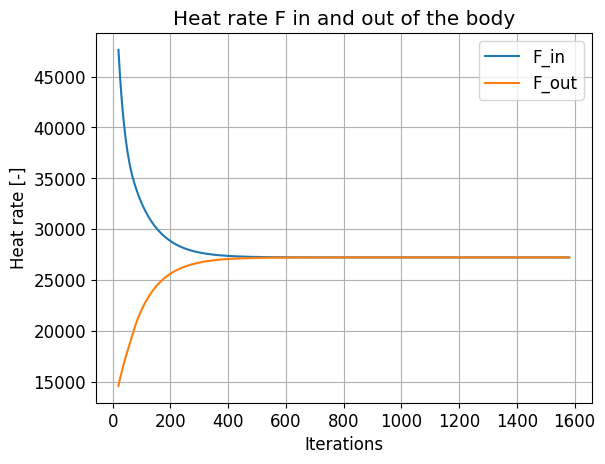

In [1008]:
# Plot the heat rate F
plt.figure()
plt.title('Heat rate F in and out of the body')
plt.xlabel('Iterations')
plt.ylabel('Heat rate [-]')
resLength = np.arange(0,len(F_vals),1)
plt.plot(resLength[20:], F_vals[20:])
plt.plot(resLength[20:], F_out_vals[20:])
plt.legend(['F_in', 'F_out'])
plt.grid()


if mesh_type == 'equidistant':
    plt.savefig('Figures/equidistant/heat_rate.png')
if mesh_type == 'non-equidistant':
    plt.savefig('Figures/non_equidistant/heat_rate.png')

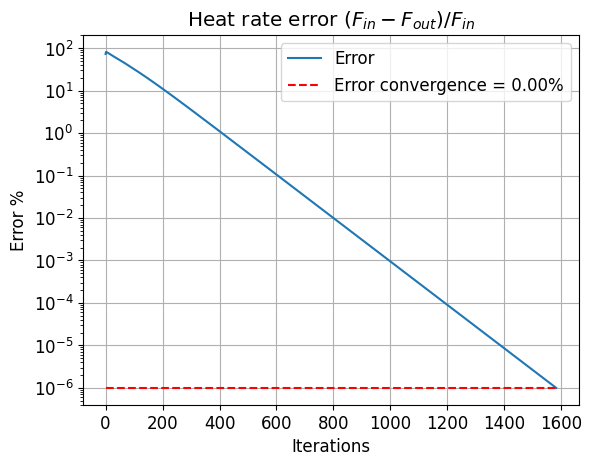

In [1009]:
# Plot the heat rate F
plt.figure()
plt.title('Heat rate error $(F_{in}-F_{out})/F_{in}$')
plt.xlabel('Iterations')
plt.ylabel('Error %')
resLength = np.arange(0,len(error_vals),1)
plt.plot(resLength, error_vals)
plt.yscale('log')
plt.hlines(y = error_vals[-1],xmax=len(error_vals),xmin=0, colors='r', linestyles='dashed')
plt.grid()
plt.legend(['Error', 'Error convergence = %.2f%%'%error_vals[-1]], loc='upper right')


if mesh_type == 'equidistant':
    plt.savefig('Figures/equidistant/heat_rate_conv.png')
if mesh_type == 'non-equidistant':
    plt.savefig('Figures/non_equidistant/heat_rate_conv.png')

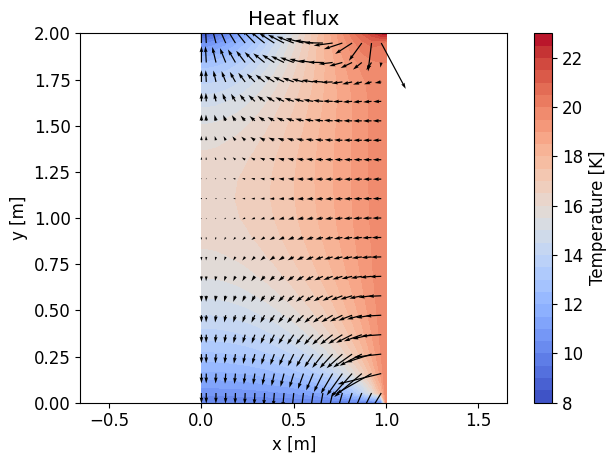

In [1013]:
# Plot heat flux vectors in nodes (not at boundaries)
qX = np.zeros((nI,nJ))*nan # Array for heat flux in x-direction, in nodes
qY = np.zeros((nI,nJ))*nan # Array for heat flux in y-direction, in nodes
for i in range(0,nI-1):
    for j in range(1,nJ-1):
            qX[i,j] = -k[i,j]*dT_dx[i,j]
            qY[i,j] = -k[i,j]*dT_dy[i,j]
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Heat flux')
plt.axis('equal')
tempmap=plt.contourf(nodeX.T,nodeY.T,T.T,cmap='coolwarm',levels=30)
plt.quiver(nodeX, nodeY, qX, qY, color="black")
cbar=plt.colorbar(tempmap)
cbar.set_label('Temperature [K]')
plt.tight_layout()
if mesh_type == 'equidistant':
    plt.savefig('Figures/equidistant/heatflux.png')
if mesh_type == 'non-equidistant':
    plt.savefig('Figures/non_equidistant/heatflux.png')

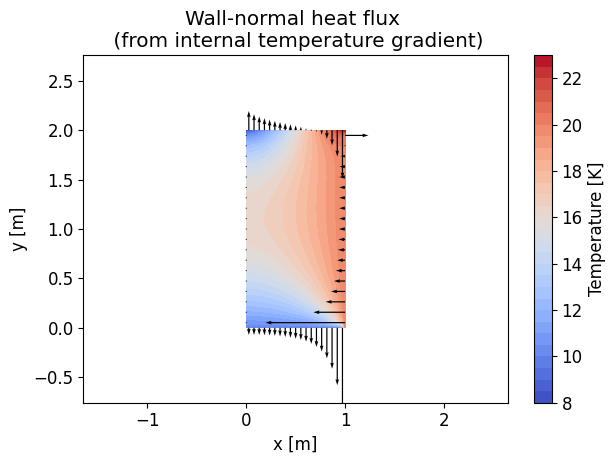

In [1011]:

# Plot heat flux vectors NORMAL TO WALL boundary face centers ONLY (not in corners)
# Use temperature gradient just inside domain (note difference to set heat flux)
qX = np.zeros((nI,nJ))*nan # Array for heat flux in x-direction, in nodes
qY = np.zeros((nI,nJ))*nan # Array for heat flux in y-direction, in nodes
for j in range(1,nJ-1):
    # west boundary
    i = 0
    qX[i,j] = -k_w[i+1,j]*dT_dx[i+1,j]*0
    qY[i,j] = 0
    # East boundary
    i = -2
    dT_dx_e = (dT_dx[i, j] -  dT_dx[i-1, j])/dx_WP[i,j] *dx_we[i,j]/2 + dT_dx[i, j]
    i = -1
    qX[i,j] = -k[i,j]*dT_dx[i,j]
    qY[i,j] = 0
for i in range(1,nI-1):
    # south boundary
    j = 1
    dT_dy_s = (dT_dy[i, j] -  dT_dy[i, j+1])/dy_PN[i,j] * dy_SP[i,j] + dT_dy[i, j]
    j = 0
    qX[i,j] = 0
    qY[i,j] = -k[i,j]*dT_dy[i,j]

    # North boundary
    j = -2
    dT_dy_n = (dT_dy[i, j] -  dT_dy[i, j-1])/dy_SP[i,j] *dy_sn[i,j]/2 + dT_dy[i, j]
    j = -1
    qX[i,j] = 0
    qY[i,j] = -k[i,j]*dT_dy[i,j]
plt.figure()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wall-normal heat flux \n (from internal temperature gradient)')
plt.axis('equal')
tempmap=plt.contourf(nodeX.T,nodeY.T,T.T,cmap='coolwarm',levels=30)
cbar=plt.colorbar(tempmap)
cbar.set_label('Temperature [K]')
plt.quiver(nodeX, nodeY, qX, qY, color="black")
plt.xlim(-0.5*L, 3/2*L)
plt.ylim(-0.5*H, 3/2*H)
plt.tight_layout()


plt.tight_layout()
if mesh_type == 'equidistant':
    plt.savefig('Figures/equidistant/wall_normal_heat_flux.png')
if mesh_type == 'non-equidistant':
    plt.savefig('Figures/non_equidistant/wall_normal_heat_flux.png')

